###Семинар 4 Сегментация изображений PSPnet

1. Изменить количество сегментирующих классов с `16` на `7`:
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`.  [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .



## Подготовка


### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

In [ ]:
!unzip -qo /content/drive/MyDrive/construction_256x192.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Решение

Для работы с сетью PSPnet, как  и Unet, изменим соотношение сторон картинки к квадрату, для лучшей работы со слоями, уменьшающими и увеличивающими количество фитчей.



Загрузим картинки в соотношении 128*128:

In [ ]:
# Глобальные параметры

IMG_WIDTH = 128               # Ширина картинки
IMG_HEIGHT = 128              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки



for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')): # Проходим по всем файлам в каталоге по указанному пути

    #  добавляем каритинку в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))



# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')): # Проходим по всем файлам в каталоге по указанному пути

    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))


# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Количество изображений:  1900
Количество изображений:  100


Загрузим сегментированные изображения:

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки



for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути

    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))



# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))



for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути

    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))


# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Количество изображений:  1900
Количество изображений:  100


In [ ]:
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

CLASSES = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
xVal = [] # Создаем пустой список под проверочную выборку

for img in train_images: # Проходим по всем изображениям из train_images
  # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  x = image.img_to_array(img)
  xTrain.append(x) # Добавляем очередной элемент в xTrain

for img in val_images: # Проходим по всем изображениям из val_images
  # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  x = image.img_to_array(img)
  xVal.append(x) # Добавляем очередной элемент в xTrain

xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размер xTrain

xVal = np.array(xVal) # Переводим в numpy
print(xVal.shape) # Размер xVal

(1900, 128, 128, 3)
(100, 128, 128, 3)


Переведем сегментированные изображения в одноканальные сегментированные с номером класса в каждом пикселе :

In [ ]:
def segment2channel(data):

  y_result = []

  for d in data: # берем RGB картику
    sample = np.array(d)
    # создаем пустую 1-канальную картику
    y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1)).astype('int')

    for i, cl in enumerate(CLASSES): # берем класс и номер класса
      # сравниваем 3-х канальный  пиксель и класс и присваиваем номер класса
      y[np.where(np.all(sample==CLASSES[i], axis=-1))] = i
    y_result.append(y)

  return np.array(y_result)

Обратная функция, перевод одноканальных сегментированных изображений с номером класса в каждом пикселе в 3х канальное RGB сегментированное изображение:

In [ ]:
def channel2segment(data):

  result = []

  for y in data: # берем 1-канальную картинку
    # создаем пустую 3х канальную картику
    temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3)).astype('int')

    for i, cl in enumerate(CLASSES): # берем класс и номер класса
      # сравниваем, заполняем 3 канала значением из CLASSES[i]
      temp[np.where(np.all(y==i, axis=-1))] = CLASSES[i]
    result.append(temp)

  return np.array(result)

Соберем сегментированные изображения в numpy-массивы xTrain и xVal:

In [ ]:
yTrain = segment2channel(train_segments)
yVal = segment2channel(val_segments)

print(yTrain.shape)
print(yVal.shape)

(1900, 128, 128, 1)
(100, 128, 128, 1)


Переведем 16 классов 7, создадим список новых классов на основе базового списка:


In [ ]:
# Создаем список списков нового распределения классов

NEW_CLASSES =((FLOOR),
              (CEILING),
              (WALL),
              (APERTURE, DOOR, WINDOW),
              (COLUMN, RAILINGS, LADDER),
              (INVENTORY),
              (LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE))

new_set_classec = []

for set_cls in NEW_CLASSES: # Проходимся по NEW_CLASSES
    n_cls = []

    for i in range(len(CLASSES)): # Проходимся по CLASSES
        # сравниваем и при совпадении условия присваиваем номер старого класса
        if CLASSES[i] in set_cls or CLASSES[i] == set_cls:
            n_cls.append(i)
    new_set_classec.append(n_cls)

print('Список номеров базовых классов, сгруппированных в новые классы:')

new_set_classec

Список номеров базовых классов, сгруппированных в новые классы:


[[0], [1], [2], [4, 5, 6], [3, 8, 11], [12], [7, 9, 10, 13, 14, 15]]

Переводим картинки из базового набора 16-ти классов в набор сгруппированых 7-ми классов:

In [ ]:
# создаем копии
yTrain7 = yTrain.copy()
yVal7 = yVal.copy()

# получаем new_cls номер нового класса и set_cls набор старых классов, к нему относящихся
for new_cls, set_cls in enumerate(new_set_classec):

   # получаем base_cls базовые классы, входящие в набор set_cls
   for base_cls in set_cls:
       yTrain7[yTrain7 == base_cls] = new_cls
       yVal7[yVal7 == base_cls] = new_cls

NUM_CLASSES = len(new_set_classec)
NUM_CLASSES

7

In [ ]:
# Функция визуализации сегментированных изображений

def processImage(model, count = 1):

  # берем случайный список индексов в количестве count между (0, len(xVal)
  indexes = np.random.randint(0, len(xVal), count)

  # получаем вектор
  predict = np.argmax(model.predict(xVal[indexes]), axis=-1)
  orig = channel2segment(predict[..., None])
  fig, axs = plt.subplots(3, count, figsize=(25, 15))

  for i in range(count):
      axs[0,0].set_title('Результат работы модели:')
      axs[0,i].imshow(orig[i]) # Отображаем на графике в первой линии
      axs[0,i].axis('off')
      axs[1,0].set_title('Оригинальное изображение')
      axs[1,i].imshow(val_images[indexes[i]]) # Отображаем на графике во второй линии сегментированное изображение из yVal
      axs[1,i].axis('off')
      axs[2,0].set_title('Оригинальное сегментированное')
      axs[2,i].imshow(val_segments[indexes[i]]) # Отображаем на графике в третьей линии оригинальное изображение
      axs[2,i].axis('off')
  plt.show()

### Создаем модель PSPnet

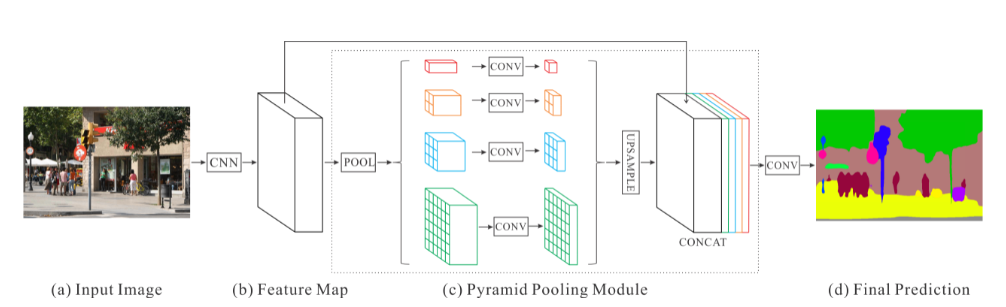

Сформируем функцию-конструктор `PSPNet`, которая, согласно изображению выше и требуемому количеству данных в глубину, будет создавать сеть структуры `PSPNet`:

In [ ]:
def PSPNet_construct(num_classes, # количество классов
                     input_shape, # размерность карты сегментации,
                     filter_main = 96,
                     kernel_main = (3,3), # размер окна входных и выходных сверточных слоев
                     filter_piramid = 64, # размер свертки внутри PSPnet блоков
                     kernel_piramid = (2,2), # размер окна внутри PSPnet блоков
                     kernel_out = (3,3), # размер окна выходного блока
                     activ_main = 'relu', # функция активации входных и выходных сверточных слоев
                     activ_piramid = 'relu', # функция активации внутри PSPnet блоков
                     levels_piramid = 4 # количество PSPnet блоков
                     ):

    # Подфункция для формирования PSPnet блока
    def pyramid_block(input,
                      frame,
                      filter,
                      kernel,
                      activ
                      ):
        x = MaxPooling2D(pool_size=frame)(input)
        x = Conv2D(filter, kernel, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(activ)(x)
        out = UpSampling2D(size=frame)(x)

        return out

    # Создаем список окон для PSPnet блока
    frames_pyramid = [2**i for i in range(1,levels_piramid+1)]

    # Создаем входной слой с размерностью input_shape
    img_input = Input(input_shape)

    # Входной блок
    x = Conv2D(filter_main, kernel_main, padding='same', name='conv_in')(img_input)
    x = BatchNormalization()(x)
    conv_in = Activation(activ_main)(x)

    ################    PSPNet блоки  ###################################
    features = [] # список features от PSPnet блока для конкетинации

    # Формируем блоки согласно списка
    for frame in frames_pyramid:
        pyramid_main = pyramid_block(img_input,
                                     frame,
                                     filter_piramid,
                                     kernel_piramid,
                                     activ_piramid)
        features.append(pyramid_main)

    # Соединяем полученные данные из разных блоков
    x = concatenate(features)
    x = Conv2D(filter_main, kernel_main, padding='same', name='conc_main')(x)
    x = BatchNormalization()(x)
    conc_main = Activation(activ_main)(x)

    # Соединяем текущие данные с данными со входа
    conc = concatenate([conc_main,  conv_in])
    x = Conv2D(filter_main, kernel_main, padding='same')(conc)
    x = BatchNormalization()(x)
    x = Activation(activ_main)(x)

   #############################################################################

    # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов
    x = Conv2D(num_classes, kernel_out, activation='softmax', padding='same')(x)

    # Создаем модель с входом 'img_input' и выходом 'x'
    model = Model(img_input, x)

    return model # Возвращаем предварительную модель

### PSPnet вариант 1

In [ ]:
PSPnet_7levels = PSPNet_construct(NUM_CLASSES,
                                  (IMG_WIDTH, IMG_HEIGHT, 3),
                                  levels_piramid = 7)
PSPnet_7levels.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 3)            0         ['input_3[0][0]']             
 D)                                                                                               
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 3)            0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                              

In [ ]:
# Компилируем модель

PSPnet_7levels.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

history = PSPnet_7levels.fit(xTrain,
                             yTrain7,
                             epochs=10,
                             batch_size=32,
                             validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

Epoch 1/10
60/60 [==============================] - 53s 457ms/step - loss: 1.1424 - sparse_categorical_accuracy: 0.5860 - val_loss: 11.1266 - val_sparse_categorical_accuracy: 0.1713
Epoch 2/10
60/60 [==============================] - 22s 368ms/step - loss: 0.9943 - sparse_categorical_accuracy: 0.6333 - val_loss: 3.9550 - val_sparse_categorical_accuracy: 0.2007
Epoch 3/10
60/60 [==============================] - 22s 371ms/step - loss: 0.9681 - sparse_categorical_accuracy: 0.6461 - val_loss: 3.2912 - val_sparse_categorical_accuracy: 0.2061
Epoch 4/10
60/60 [==============================] - 23s 379ms/step - loss: 0.9382 - sparse_categorical_accuracy: 0.6571 - val_loss: 1.6763 - val_sparse_categorical_accuracy: 0.4620
Epoch 5/10
60/60 [==============================] - 23s 385ms/step - loss: 0.9264 - sparse_categorical_accuracy: 0.6614 - val_loss: 1.2851 - val_sparse_categorical_accuracy: 0.5220
Epoch 6/10
60/60 [==============================] - 23s 386ms/step - loss: 0.9068 - sparse_cat

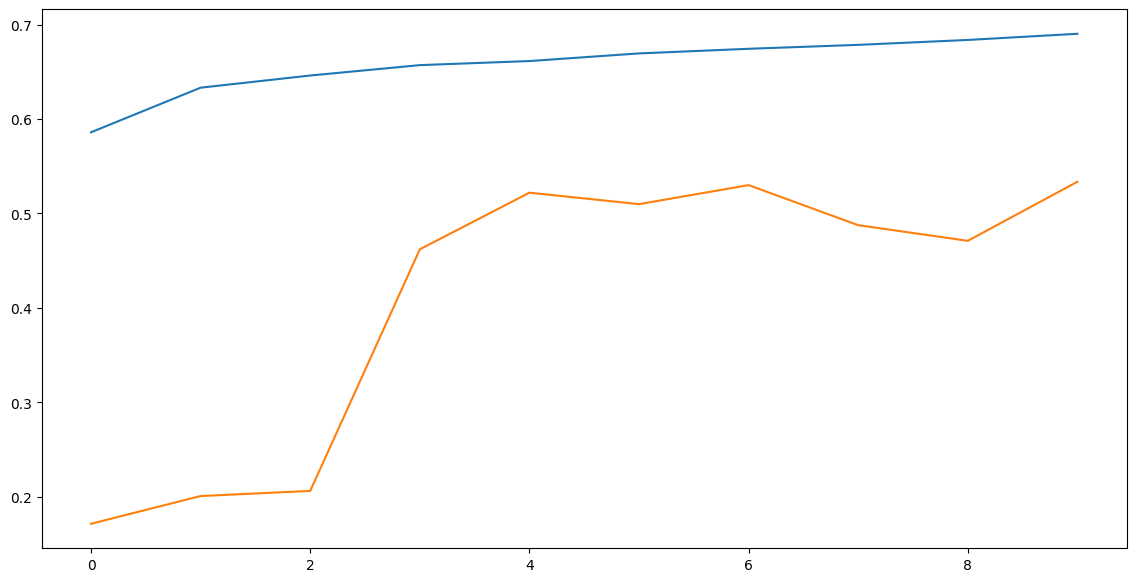

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

Уменьшим learning_rate и поучим еще:

In [ ]:
# Компилируем модель

PSPnet_7levels.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

history = PSPnet_7levels.fit(xTrain,
                             yTrain7,
                             epochs=10,
                             batch_size=32,
                             validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

Epoch 1/10
60/60 [==============================] - 29s 388ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.7050 - val_loss: 1.1290 - val_sparse_categorical_accuracy: 0.5858
Epoch 2/10
60/60 [==============================] - 23s 392ms/step - loss: 0.8037 - sparse_categorical_accuracy: 0.7097 - val_loss: 1.0998 - val_sparse_categorical_accuracy: 0.5927
Epoch 3/10
60/60 [==============================] - 23s 385ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.7110 - val_loss: 1.1332 - val_sparse_categorical_accuracy: 0.5852
Epoch 4/10
60/60 [==============================] - 23s 386ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.7126 - val_loss: 1.0870 - val_sparse_categorical_accuracy: 0.5970
Epoch 5/10
60/60 [==============================] - 23s 388ms/step - loss: 0.7911 - sparse_categorical_accuracy: 0.7143 - val_loss: 1.1354 - val_sparse_categorical_accuracy: 0.5815
Epoch 6/10
60/60 [==============================] - 23s 389ms/step - loss: 0.7895 - sparse_cate

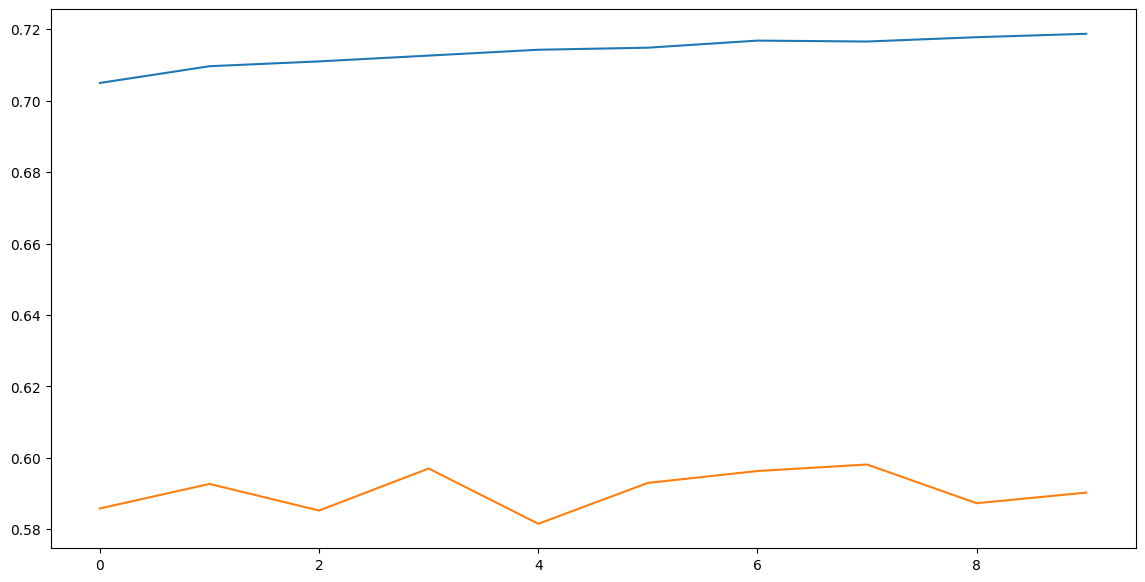

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

Уменьшим learning_rate и поучим еще:

In [ ]:
# Компилируем модель

PSPnet_7levels.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

history = PSPnet_7levels.fit(xTrain,
                             yTrain7,
                             epochs=10,
                             batch_size=24,
                             validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

Epoch 1/10
80/80 [==============================] - 38s 316ms/step - loss: 0.7747 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.5984
Epoch 2/10
80/80 [==============================] - 24s 305ms/step - loss: 0.7707 - sparse_categorical_accuracy: 0.7224 - val_loss: 1.0889 - val_sparse_categorical_accuracy: 0.5991
Epoch 3/10
80/80 [==============================] - 25s 308ms/step - loss: 0.7736 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.5981
Epoch 4/10
80/80 [==============================] - 24s 304ms/step - loss: 0.7739 - sparse_categorical_accuracy: 0.7213 - val_loss: 1.0896 - val_sparse_categorical_accuracy: 0.5987
Epoch 5/10
80/80 [==============================] - 24s 303ms/step - loss: 0.7707 - sparse_categorical_accuracy: 0.7224 - val_loss: 1.0864 - val_sparse_categorical_accuracy: 0.5997
Epoch 6/10
80/80 [==============================] - 25s 307ms/step - loss: 0.7719 - sparse_cate

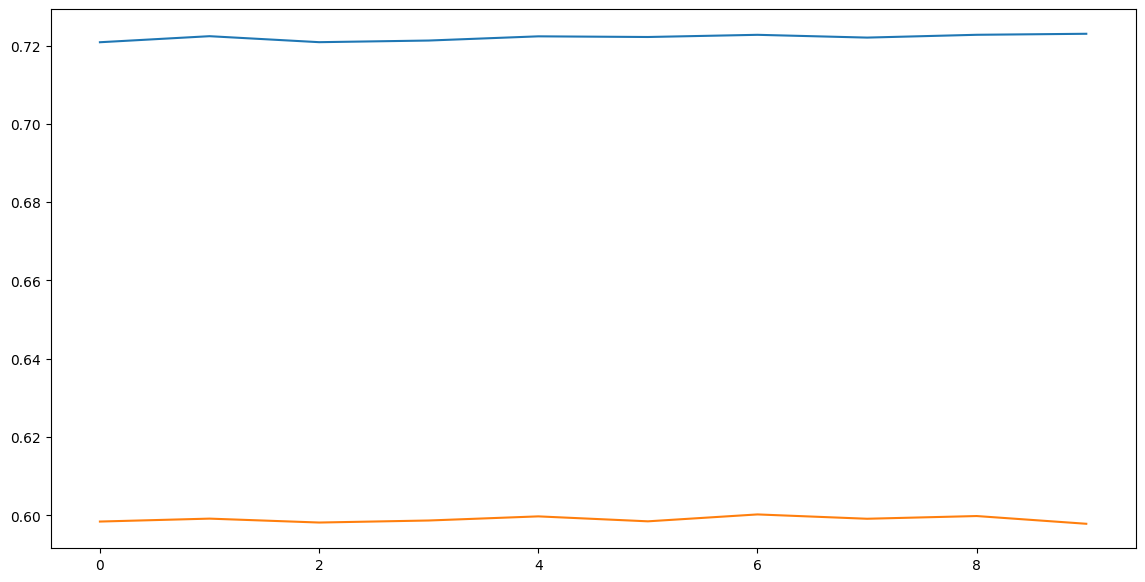

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

1/1 [==============================] - 2s 2s/step


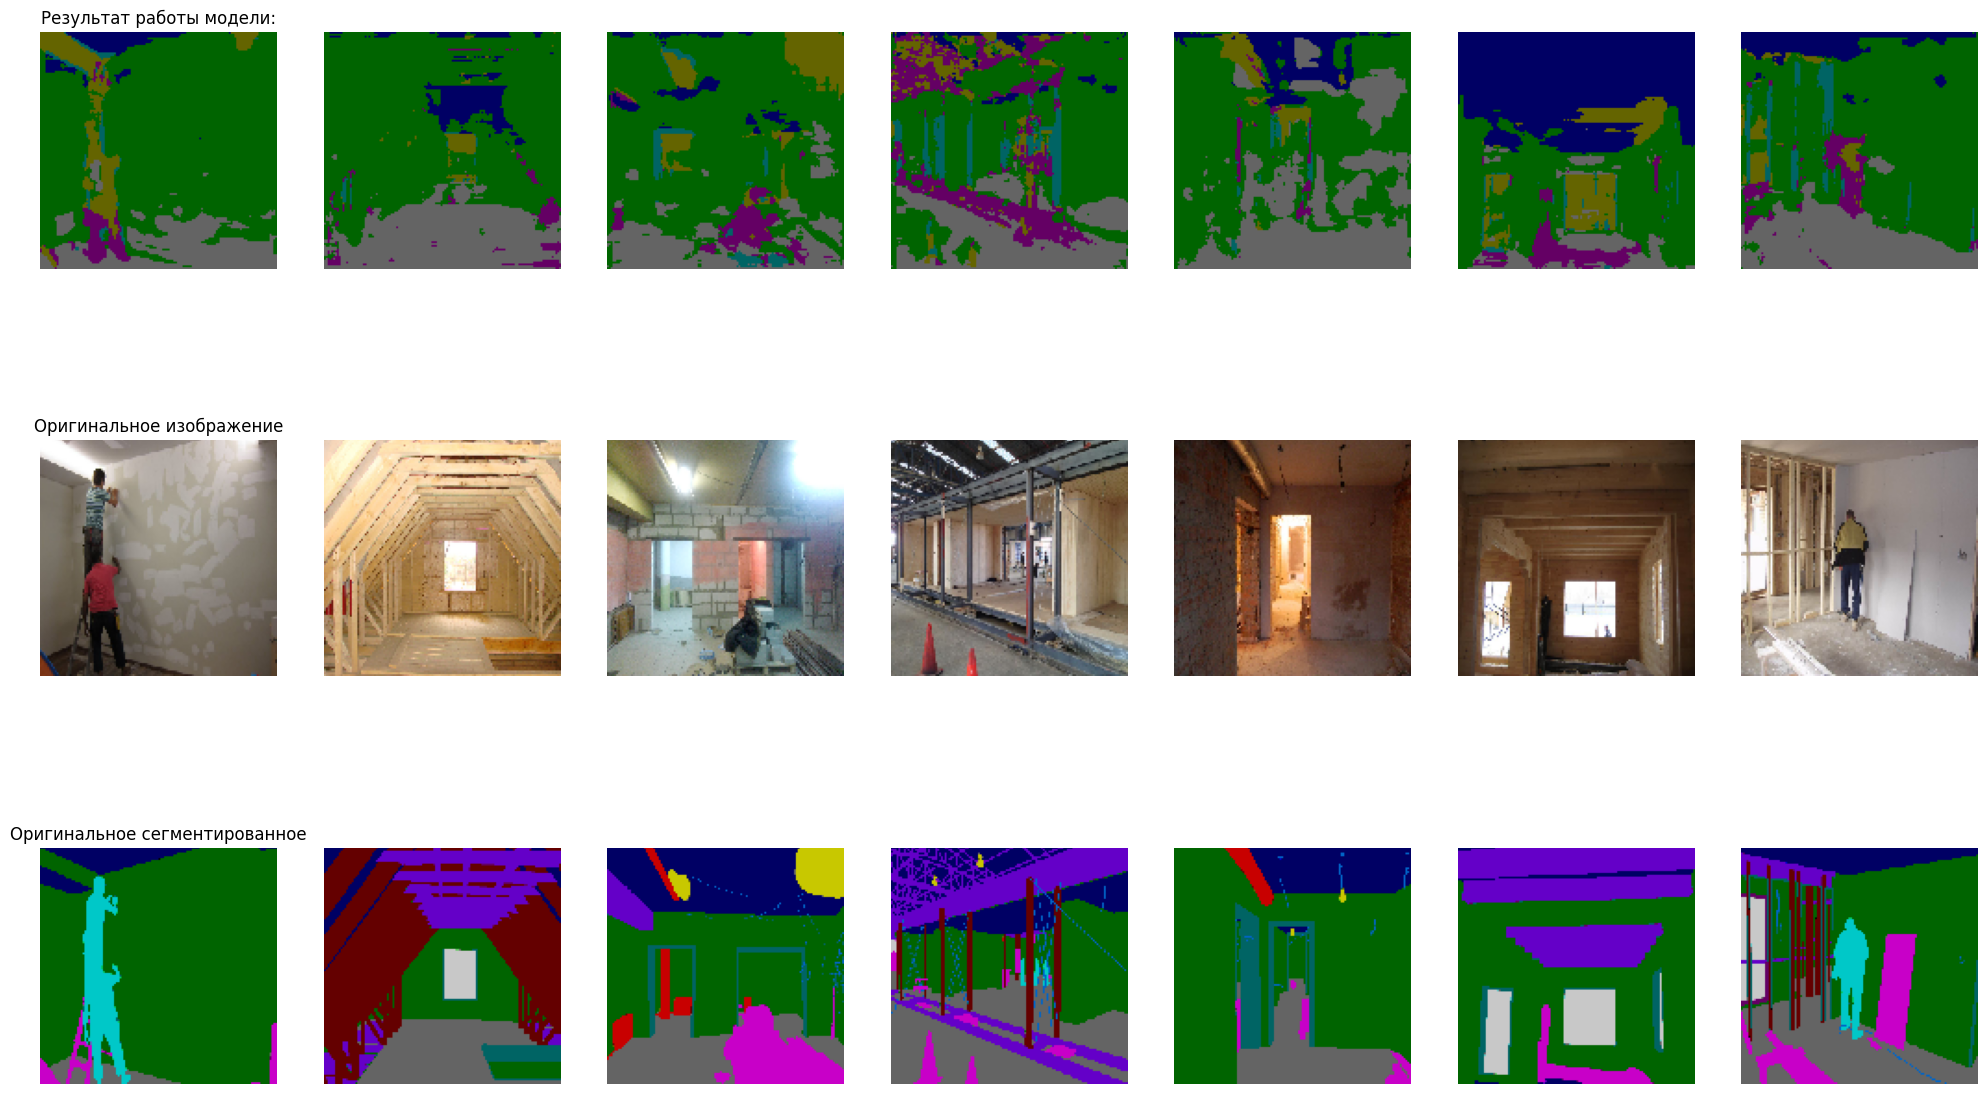

In [ ]:
processImage(PSPnet_7levels, 7)

### PSPnet вариант 2

In [ ]:
PSPnet_7levels_more = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),
                                       filter_main = 128,
                                       kernel_main = (2,2),
                                       filter_piramid = 128,
                                       kernel_piramid = (4,4),
                                       kernel_out = (2,2),
                                       activ_main = 'relu',
                                       activ_piramid = 'elu',
                                       levels_piramid = 7)

PSPnet_7levels_more.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 3)            0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 3)            0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
learning_rate = 1e-3
epochs = 5
etaps = 3
val_loss_full = []
val_acc_full = []

for etap in range(etaps):
    learning_rate /= 10
    print('Этап ', etap+1, '('+str(etaps)+')')
    print('learning_rate ', learning_rate)

    # Компилируем модель

    PSPnet_7levels_more.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = PSPnet_7levels_more.fit(xTrain,
                                      yTrain7,
                                      epochs=epochs,
                                      batch_size=24,
                                      validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

    val_loss = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    val_loss_full.extend(val_loss)
    val_acc_full.extend(val_acc)
    print()


Этап  1 (3)
learning_rate  0.0001
Epoch 1/5
80/80 [==============================] - 92s 885ms/step - loss: 1.4504 - sparse_categorical_accuracy: 0.5035 - val_loss: 2.6416 - val_sparse_categorical_accuracy: 0.1871
Epoch 2/5
80/80 [==============================] - 66s 821ms/step - loss: 1.0935 - sparse_categorical_accuracy: 0.6149 - val_loss: 1.4833 - val_sparse_categorical_accuracy: 0.4614
Epoch 3/5
80/80 [==============================] - 66s 822ms/step - loss: 1.0413 - sparse_categorical_accuracy: 0.6268 - val_loss: 1.3778 - val_sparse_categorical_accuracy: 0.4917
Epoch 4/5
80/80 [==============================] - 66s 821ms/step - loss: 1.0113 - sparse_categorical_accuracy: 0.6347 - val_loss: 1.2899 - val_sparse_categorical_accuracy: 0.5088
Epoch 5/5
80/80 [==============================] - 66s 823ms/step - loss: 0.9950 - sparse_categorical_accuracy: 0.6397 - val_loss: 1.1901 - val_sparse_categorical_accuracy: 0.5645

Этап  2 (3)
learning_rate  1e-05
Epoch 1/5
80/80 [===============

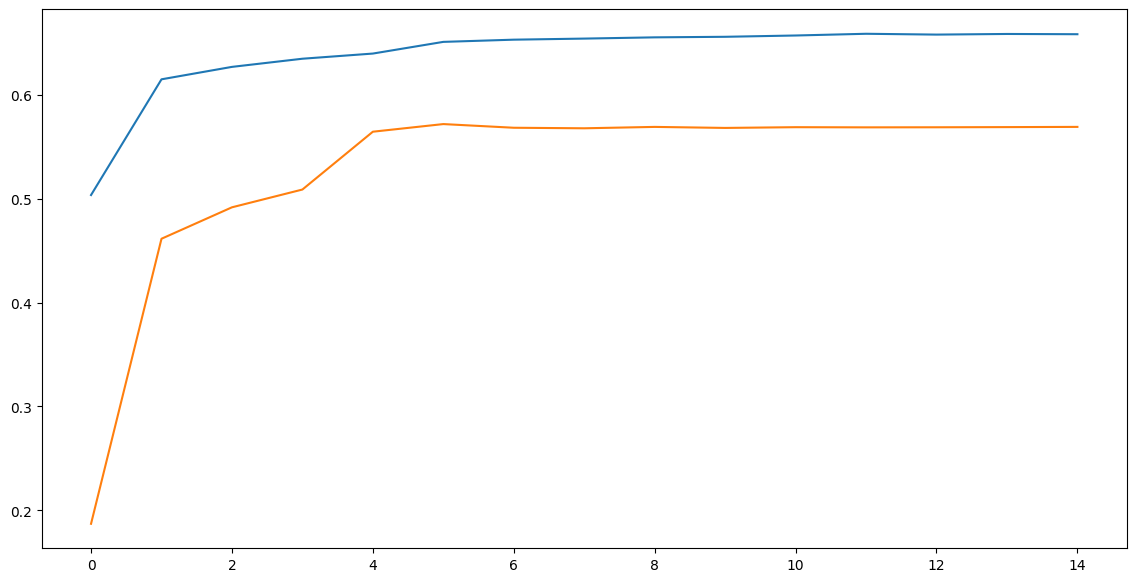

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(val_loss_full)
plt.plot(val_acc_full)
plt.show()

1/1 [==============================] - 3s 3s/step


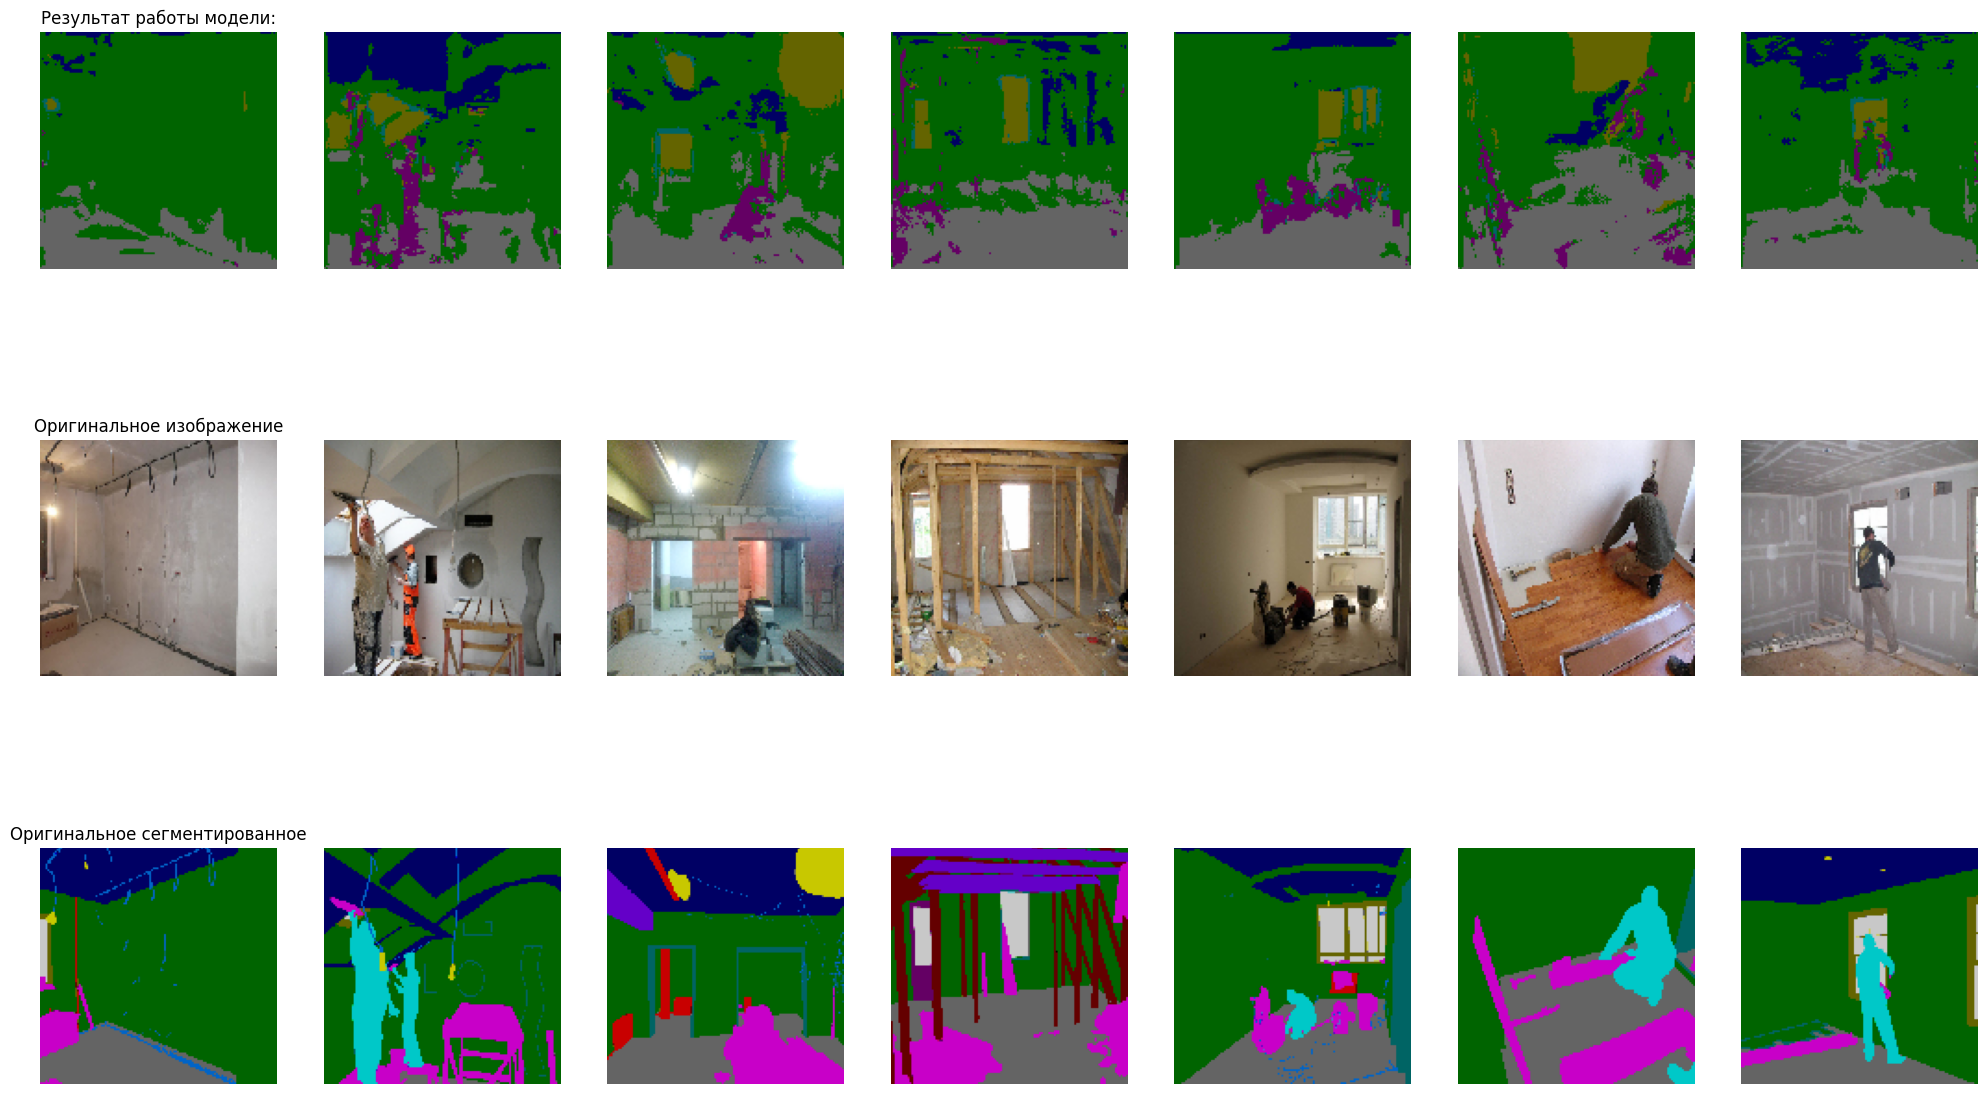

In [ ]:
processImage(PSPnet_7levels_more, 7)

### PSPnet вариант 3

In [ ]:
PSPnet_7levels_more = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),
                                       filter_main = 64,
                                       kernel_main = (3,3),
                                       filter_piramid = 256,
                                       kernel_piramid = (2,2),
                                       kernel_out = (3,3),
                                       activ_main = 'relu',
                                       activ_piramid = 'elu',
                                       levels_piramid = 7)

PSPnet_7levels_more.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 max_pooling2d_21 (MaxPooli  (None, 64, 64, 3)            0         ['input_6[0][0]']             
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 32, 32, 3)            0         ['input_6[0][0]']             
 ng2D)                                                                                            
                                                                                            

In [ ]:
learning_rate = 1e-2
epochs = 4
etaps = 2
val_loss_full = []
val_acc_full = []

for etap in range(etaps):
    learning_rate /= 10
    print('Этап ', etap+1, '('+str(etaps)+')')
    print('learning_rate ', learning_rate)

    # Компилируем модель

    PSPnet_7levels_more.compile(optimizer=Adam(learning_rate=learning_rate),
                                loss='sparse_categorical_crossentropy',
                                metrics=['sparse_categorical_accuracy'])

    history = PSPnet_7levels_more.fit(xTrain,
                                      yTrain7,
                                      epochs=epochs,
                                      batch_size=24,
                                      validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

    val_loss = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    val_loss_full.extend(val_loss)
    val_acc_full.extend(val_acc)
    print()


Этап  1 (2)
learning_rate  0.001
Epoch 1/4
80/80 [==============================] - 74s 832ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.5748 - val_loss: 3.2426 - val_sparse_categorical_accuracy: 0.2559
Epoch 2/4
80/80 [==============================] - 66s 822ms/step - loss: 1.0299 - sparse_categorical_accuracy: 0.6225 - val_loss: 2.4155 - val_sparse_categorical_accuracy: 0.2865
Epoch 3/4
80/80 [==============================] - 66s 819ms/step - loss: 0.9984 - sparse_categorical_accuracy: 0.6331 - val_loss: 1.3013 - val_sparse_categorical_accuracy: 0.5397
Epoch 4/4
80/80 [==============================] - 66s 824ms/step - loss: 0.9752 - sparse_categorical_accuracy: 0.6422 - val_loss: 1.3229 - val_sparse_categorical_accuracy: 0.4533

Этап  2 (2)
learning_rate  0.0001
Epoch 1/4
80/80 [==============================] - 73s 833ms/step - loss: 0.9313 - sparse_categorical_accuracy: 0.6604 - val_loss: 1.1629 - val_sparse_categorical_accuracy: 0.5659
Epoch 2/4
80/80 [===============

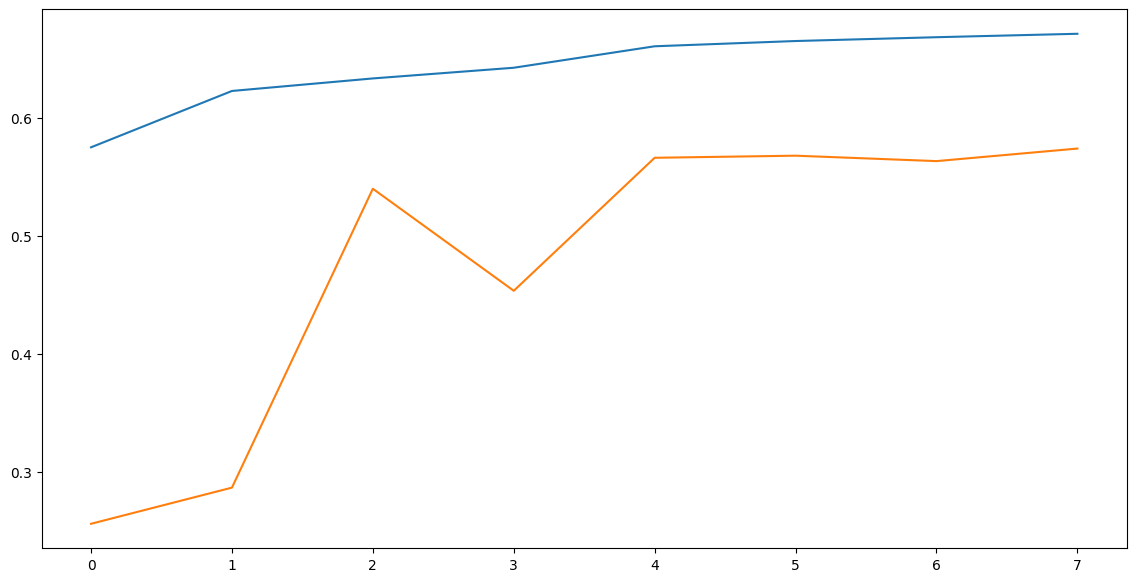

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(val_loss_full)
plt.plot(val_acc_full)
plt.show()

### PSPnet вариант 4

In [ ]:
PSPnet_7levels_more = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),
                                       filter_main = 256,
                                       kernel_main = (2,2),
                                       filter_piramid = 128,
                                       kernel_piramid = (3,3),
                                       kernel_out = (3,3),
                                       activ_main = 'elu',
                                       activ_piramid = 'elu',
                                       levels_piramid = 7)

PSPnet_7levels_more.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 3)            0         ['input_7[0][0]']             
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_29 (MaxPooli  (None, 32, 32, 3)            0         ['input_7[0][0]']             
 ng2D)                                                                                            
                                                                                            

In [ ]:
learning_rate = 1e-2
epochs = 4
etaps = 2
val_loss_full = []
val_acc_full = []

for etap in range(etaps):
    learning_rate /= 10
    print('Этап ', etap+1, '('+str(etaps)+')')
    print('learning_rate ', learning_rate)

    # Компилируем модель

    PSPnet_7levels_more.compile(optimizer=Adam(learning_rate=learning_rate),
                                loss='sparse_categorical_crossentropy',
                                metrics=['sparse_categorical_accuracy'])

    history = PSPnet_7levels_more.fit(xTrain,
                                      yTrain7,
                                      epochs=epochs,
                                      batch_size=24,
                                      validation_data = (xVal, yVal7)) # Обучаем модель на выборке по трем классам

    val_loss = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    val_loss_full.extend(val_loss)
    val_acc_full.extend(val_acc)
    print()


Этап  1 (2)
learning_rate  0.001
Epoch 1/4
80/80 [==============================] - 121s 1s/step - loss: 1.2005 - sparse_categorical_accuracy: 0.5719 - val_loss: 3.7896 - val_sparse_categorical_accuracy: 0.2141
Epoch 2/4
80/80 [==============================] - 96s 1s/step - loss: 1.0438 - sparse_categorical_accuracy: 0.6171 - val_loss: 2.3205 - val_sparse_categorical_accuracy: 0.3795
Epoch 3/4
80/80 [==============================] - 96s 1s/step - loss: 1.0292 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.7644 - val_sparse_categorical_accuracy: 0.4090
Epoch 4/4
80/80 [==============================] - 96s 1s/step - loss: 1.0115 - sparse_categorical_accuracy: 0.6282 - val_loss: 1.6451 - val_sparse_categorical_accuracy: 0.4160

Этап  2 (2)
learning_rate  0.0001
Epoch 1/4
80/80 [==============================] - 103s 1s/step - loss: 0.9490 - sparse_categorical_accuracy: 0.6524 - val_loss: 1.2321 - val_sparse_categorical_accuracy: 0.5755
Epoch 2/4
80/80 [============================

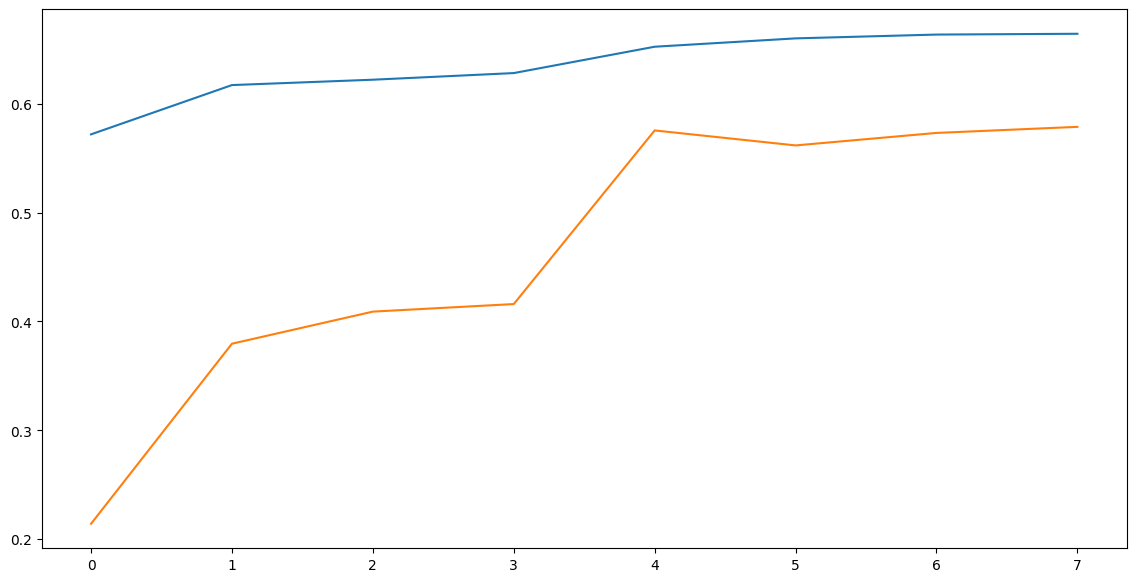

In [ ]:
# Отобразим график обучения модели

plt.figure(figsize=(14,7))
plt.plot(val_loss_full)
plt.plot(val_acc_full)
plt.show()

1/1 [==============================] - 3s 3s/step


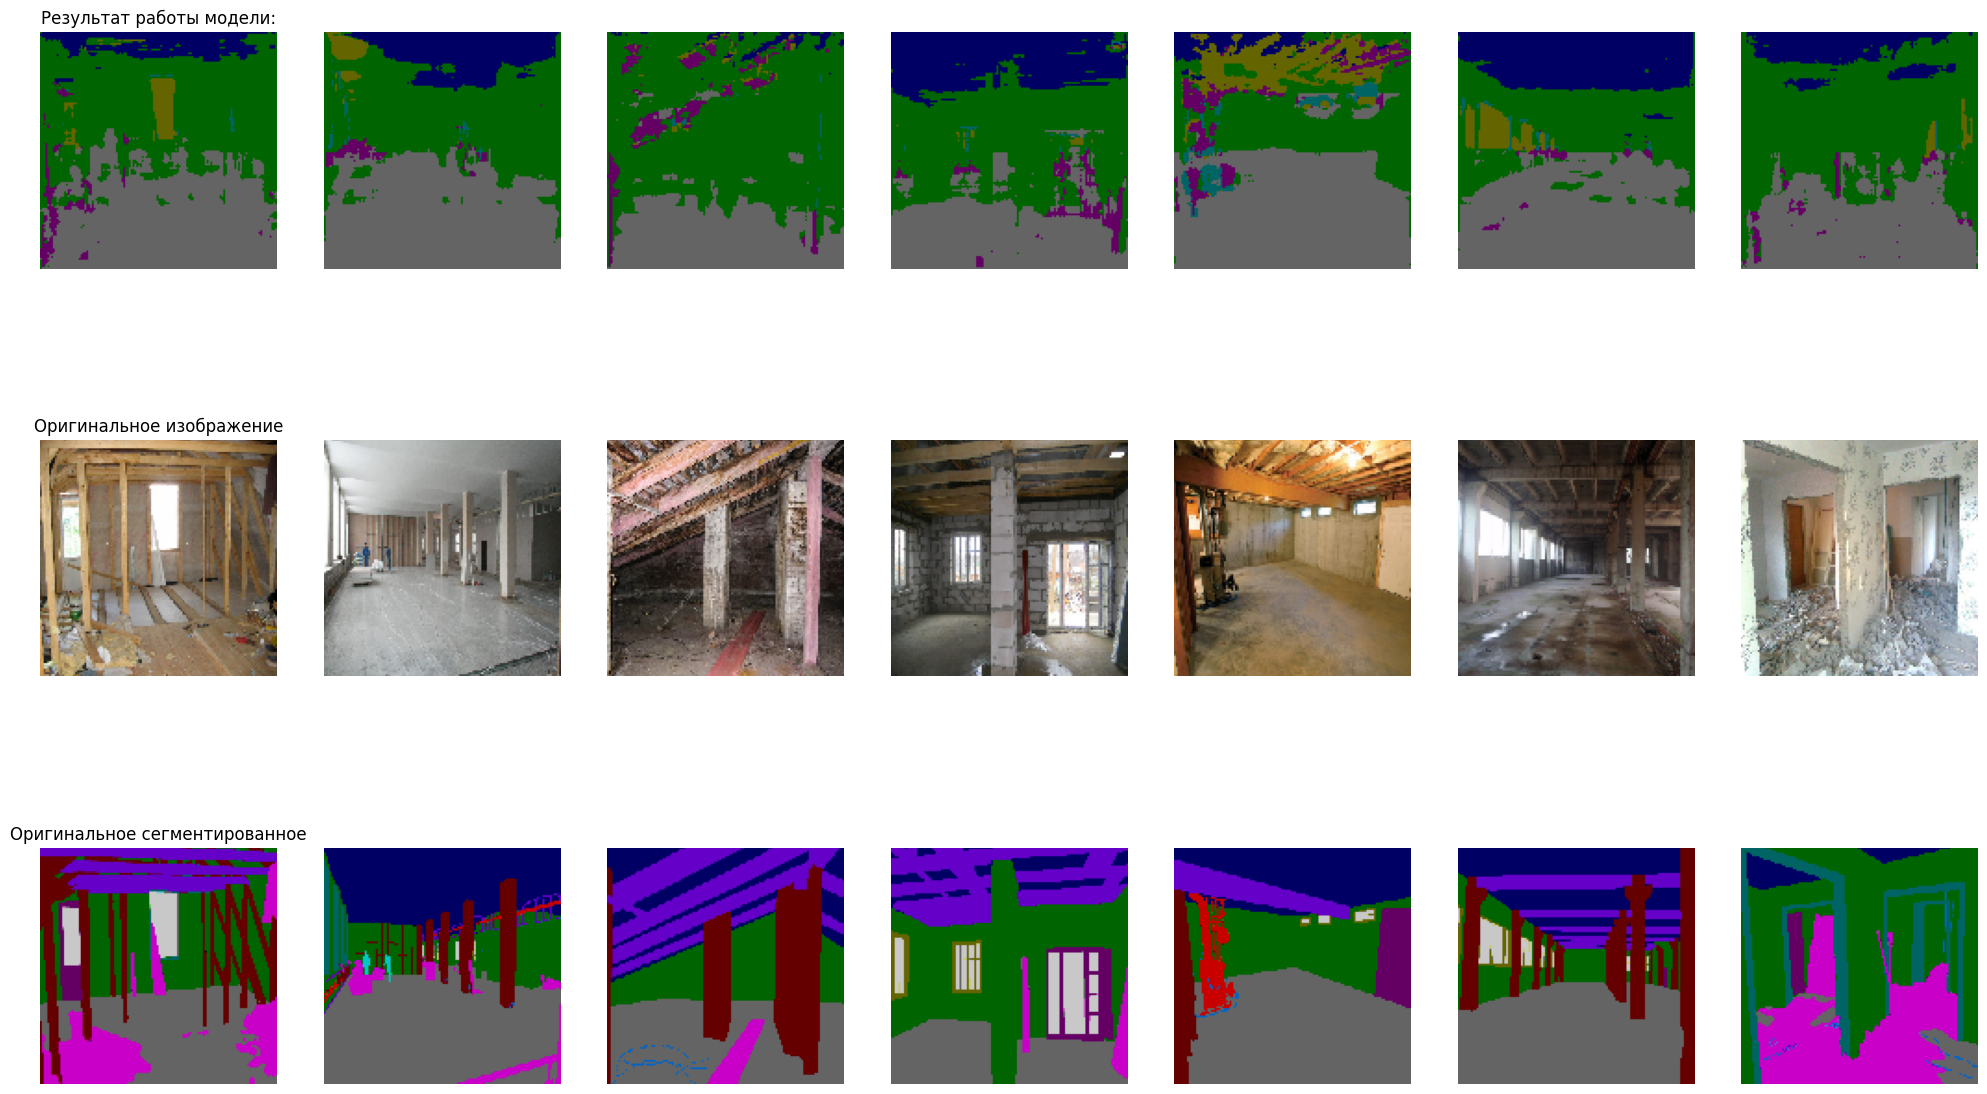

In [ ]:
processImage(PSPnet_7levels_more, 7)